# Tuning the probability threshold

[Machine Learning with Imbalanced Data - Course](https://www.trainindata.com/p/machine-learning-with-imbalanced-data)

In this notebook, we'll discuss how to obtain a prediction based on probability thresholds different from 0.5.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import (
    train_test_split,
    FixedThresholdClassifier,
    TunedThresholdClassifierCV,
)

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
)

import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
# load data
data = pd.read_csv('../kdd2004.csv')

# remap target class to 0 and 1
data['target'] = data['target'].map({-1:0, 1:1})

data.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
0,52.0,32.69,0.30,2.5,20.0,1256.8,-0.89,0.33,11.0,-55.0,...,1595.1,-1.64,2.83,-2.0,-50.0,445.2,-0.35,0.26,0.76,0
1,58.0,33.33,0.00,16.5,9.5,608.1,0.50,0.07,20.5,-52.5,...,762.9,0.29,0.82,-3.0,-35.0,140.3,1.16,0.39,0.73,0
2,77.0,27.27,-0.91,6.0,58.5,1623.6,-1.40,0.02,-6.5,-48.0,...,1491.8,0.32,-1.29,0.0,-34.0,658.2,-0.76,0.26,0.24,0
3,41.0,27.91,-0.35,3.0,46.0,1921.6,-1.36,-0.47,-32.0,-51.5,...,2047.7,-0.98,1.53,0.0,-49.0,554.2,-0.83,0.39,0.73,0
4,50.0,28.00,-1.32,-9.0,12.0,464.8,0.88,0.19,8.0,-51.5,...,479.5,0.68,-0.59,2.0,-36.0,-6.9,2.02,0.14,-0.23,0


In [3]:
# imbalanced target

data.target.value_counts(normalize=True)

target
0    0.991108
1    0.008892
Name: proportion, dtype: float64

In [4]:
# separate dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),  # drop the target
    data['target'],  # just the target
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((102025, 74), (43726, 74))

## Logistic Regression

In [5]:
logit = LogisticRegression(random_state=0,  max_iter=1000)

logit.fit(X_train, y_train)

# probability predictions
pred_train = logit.predict_proba(X_train)[:,1]
pred_test = logit.predict_proba(X_test)[:,1]

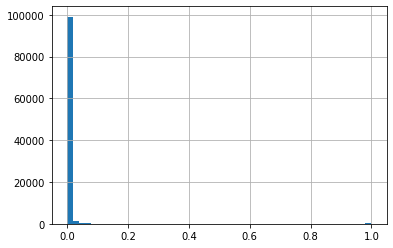

In [6]:
pd.Series(pred_train).hist(bins=50)
plt.show()

## Fixed threshold - manual

In [7]:
# set up a function to define a class based
# on a threshold

def predict(prob, threshold):
    return np.where(prob>threshold, 1, 0)

In [8]:
# the traditional threshold of 0.5

pred = predict(pred_test, 0.5)

print('Recall test:', recall_score(y_test, pred))
print('Precision test: ', precision_score(y_test, pred))
print('fscore test:', f1_score(y_test, pred))
print('balanced accuracy test:', balanced_accuracy_score(y_test, pred))

Recall test: 0.7160493827160493
Precision test:  0.9508196721311475
fscore test: 0.8169014084507042
balanced accuracy test: 0.8578515651605685


In [9]:
# lower threshold

pred = predict(pred_test, 0.2)

print('Recall test:', recall_score(y_test, pred))
print('Precision test: ', precision_score(y_test, pred))
print('fscore test:', f1_score(y_test, pred))
print('balanced accuracy test:', balanced_accuracy_score(y_test, pred))

Recall test: 0.7950617283950617
Precision test:  0.8496042216358839
fscore test: 0.8214285714285714
balanced accuracy test: 0.8968729846471973


In [10]:
# even lower

pred = predict(pred_test, 0.1)

print('Recall test:', recall_score(y_test, pred))
print('Precision test: ', precision_score(y_test, pred))
print('fscore test:', f1_score(y_test, pred))
print('balanced accuracy test:', balanced_accuracy_score(y_test, pred))

Recall test: 0.8296296296296296
Precision test:  0.680161943319838
fscore test: 0.7474972191323693
balanced accuracy test: 0.9129912188682762


## Fixed Threshold - sklearn

In [11]:
# instead, you can wrap an sklearn classifier to
# return a class based on a fixed threshold

logit_flex = FixedThresholdClassifier(
    logit, 
    threshold=0.2, 
    response_method="predict_proba",
).fit(X_train, y_train)

In [12]:
# now, when we invoke predict, it applies a threshold
# of 0.2 instead.

pred = logit_flex.predict(X_test)

print('Recall test:', recall_score(y_test, pred))
print('Precision test: ', precision_score(y_test, pred))
print('fscore test:', f1_score(y_test, pred))
print('balanced accuracy test:', balanced_accuracy_score(y_test, pred))

Recall test: 0.7950617283950617
Precision test:  0.8496042216358839
fscore test: 0.8214285714285714
balanced accuracy test: 0.8968729846471973


## Tuned threshold

Finding the best threshold for a given metric.

In [13]:
logit_tuned = TunedThresholdClassifierCV(
    logit, 
    scoring="balanced_accuracy",
    cv=3,
).fit(X_train, y_train)

print(
    f"Cut-off point found at {logit_tuned.best_threshold_:.3f}"
)

Cut-off point found at 0.010


In [14]:
pred = logit_tuned.predict(X_test)

print('Recall test:', recall_score(y_test, pred))
print('Precision test: ', precision_score(y_test, pred))
print('fscore test:', f1_score(y_test, pred))
print('balanced accuracy test:', balanced_accuracy_score(y_test, pred))

Recall test: 0.9333333333333333
Precision test:  0.18129496402877698
fscore test: 0.3036144578313253
balanced accuracy test: 0.9469649053961513
